In [21]:
# for emacs jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn models & tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.utils import resample

fit_gaussians = False
use_plotly = True

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

n_majority = train.loc[train.target==0].shape[0]
n_minority = train.loc[train.target==1].shape[0]

print("There are {} transactions.".format(n_minority))
print("There are {} non-transactions.".format(n_majority))
print("There are {} total samples.".format(train.shape[0]))
print("There are {} total features".format(train.shape[1]))

There are 20098 transactions.
There are 179902 non-transactions.
There are 200000 total samples.
There are 202 total features


In [3]:
# Separate majority and classes
train_majority = train[train.target==0]
train_minority = train[train.target==1]

# Upsample minority class
train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=n_majority,
    random_state=42,
)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Display new class counts
train_upsampled.target.value_counts()


1    179902
0    179902
Name: target, dtype: int64

In [4]:
# Shuffle the whole dataset
train_upsampled = train_upsampled.sample(frac=1, random_state=42)
train_upsampled.head(5)

             ID_code  target    var_0   var_1    var_2   var_3    var_4  \
69187    train_69187       0  12.5315 -6.2986  12.0455  4.5815  11.9221   
123517  train_123517       1  14.8534  1.5838   7.3747  4.8189  14.2518   
173733  train_173733       1   6.1158 -5.7233  10.7570  9.0032   8.4165   
45833    train_45833       0  14.0086 -4.2193   9.5692  9.4663  13.0903   
59296    train_59296       0   9.9176  4.5023  11.3207  4.1995  10.9664   

          var_5   var_6    var_7  ...  var_190  var_191  var_192  var_193  \
69187   -8.1443  4.1712  14.8247  ...   4.0441   8.9833   1.2665  11.2106   
123517 -10.0314  6.9726  19.5570  ...   4.8216   5.9931   0.6959   6.9243   
173733   9.8779  5.7910  20.4260  ...   8.4389   3.1705   1.8480   4.4542   
45833   -7.3065  5.8991  13.4569  ...   6.1976   5.4212   0.6616   3.5888   
59296   -5.7841  4.8291  14.9291  ...   4.1967  14.8190   2.1388   4.4838   

        var_194  var_195  var_196  var_197  var_198  var_199  
69187   13.9807   0.647

In [6]:
train_upsampled.target.dtype

dtype('int64')

In [7]:
org_vars = train_upsampled.drop(["target", "ID_code"], axis=1).columns.values
len(org_vars)

200

In [8]:
type(org_vars)

numpy.ndarray

In [9]:
train_upsampled["Id"] = train_upsampled.index.values
original_trainid = train_upsampled.ID_code.values

train_upsampled.drop("ID_code", axis=1, inplace=True)

In [10]:
train_upsampled.isnull().sum().sum()

0

In [11]:
test.head(5)

  ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7

In [12]:
test.isnull().sum().sum()

0

In [13]:
test.shape

(200000, 201)

In [14]:
test["Id"] = test.index.values
original_testid = test.ID_code.values

test.drop("ID_code", axis=1, inplace=True)

In [15]:
submission.head()

  ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0

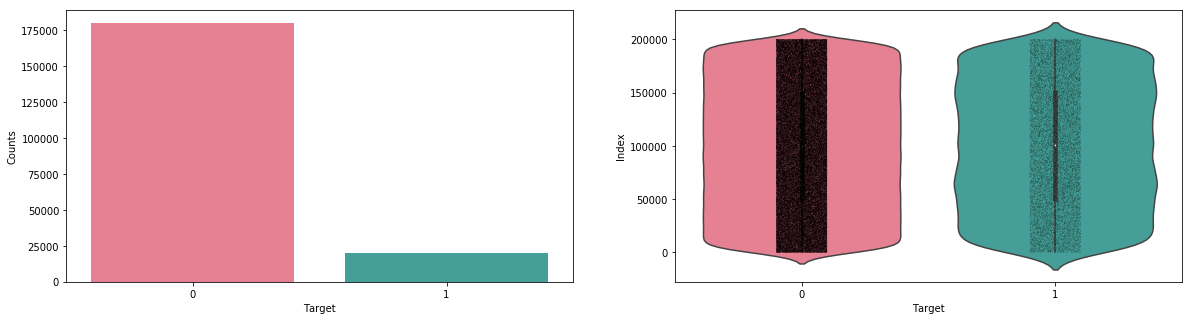

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=train.target.values, y=train.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=train.target.values, y=train.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index");
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");



In [55]:
train.loc[train.target==1].shape[0] / train.loc[train.target==0].shape[0]

0.1117163789174106

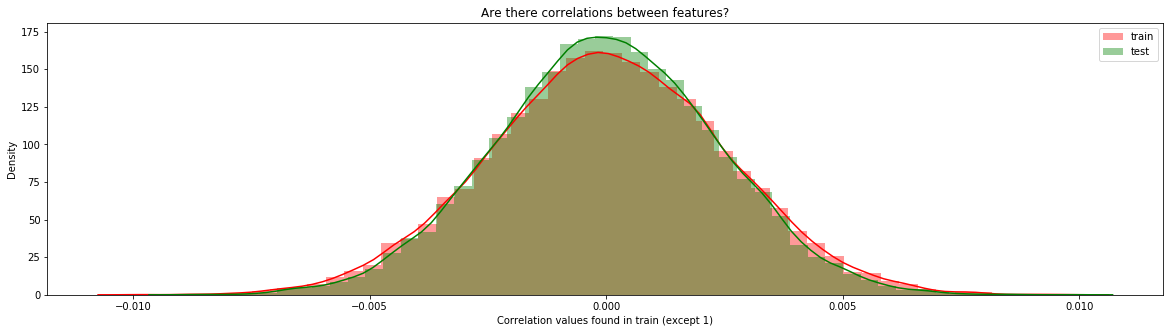

In [56]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20, 5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?");
plt.legend();

In [23]:
parameters = {"min_samples_leaf": [20, 25]}
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, parameters, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))

In [24]:
grid.fit(train_upsampled.drop("target", axis=1).values, train_upsampled.target.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.3min remaining:  1.3min


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

In [25]:
grid.best_score_

0.8555241186868406

In [26]:
grid.best_params_

{'min_samples_leaf': 20}

Text(0.5, 1.0, 'Waht are the top important features to start with?')

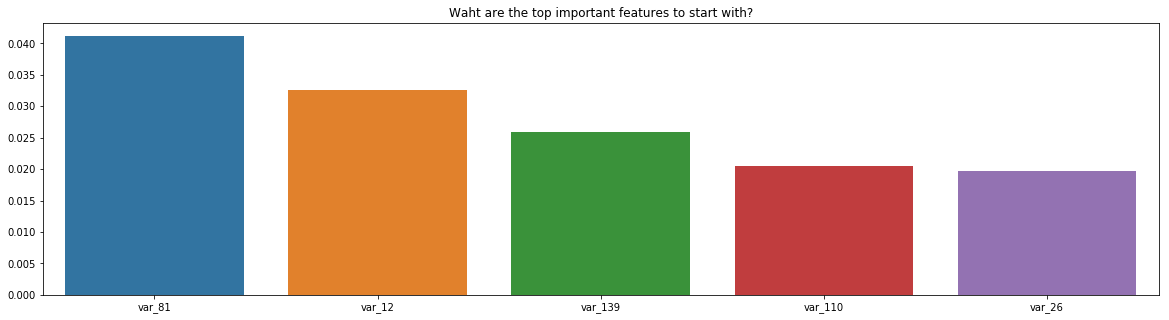

In [61]:
n_top = 5
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Waht are the top important features to start with?")

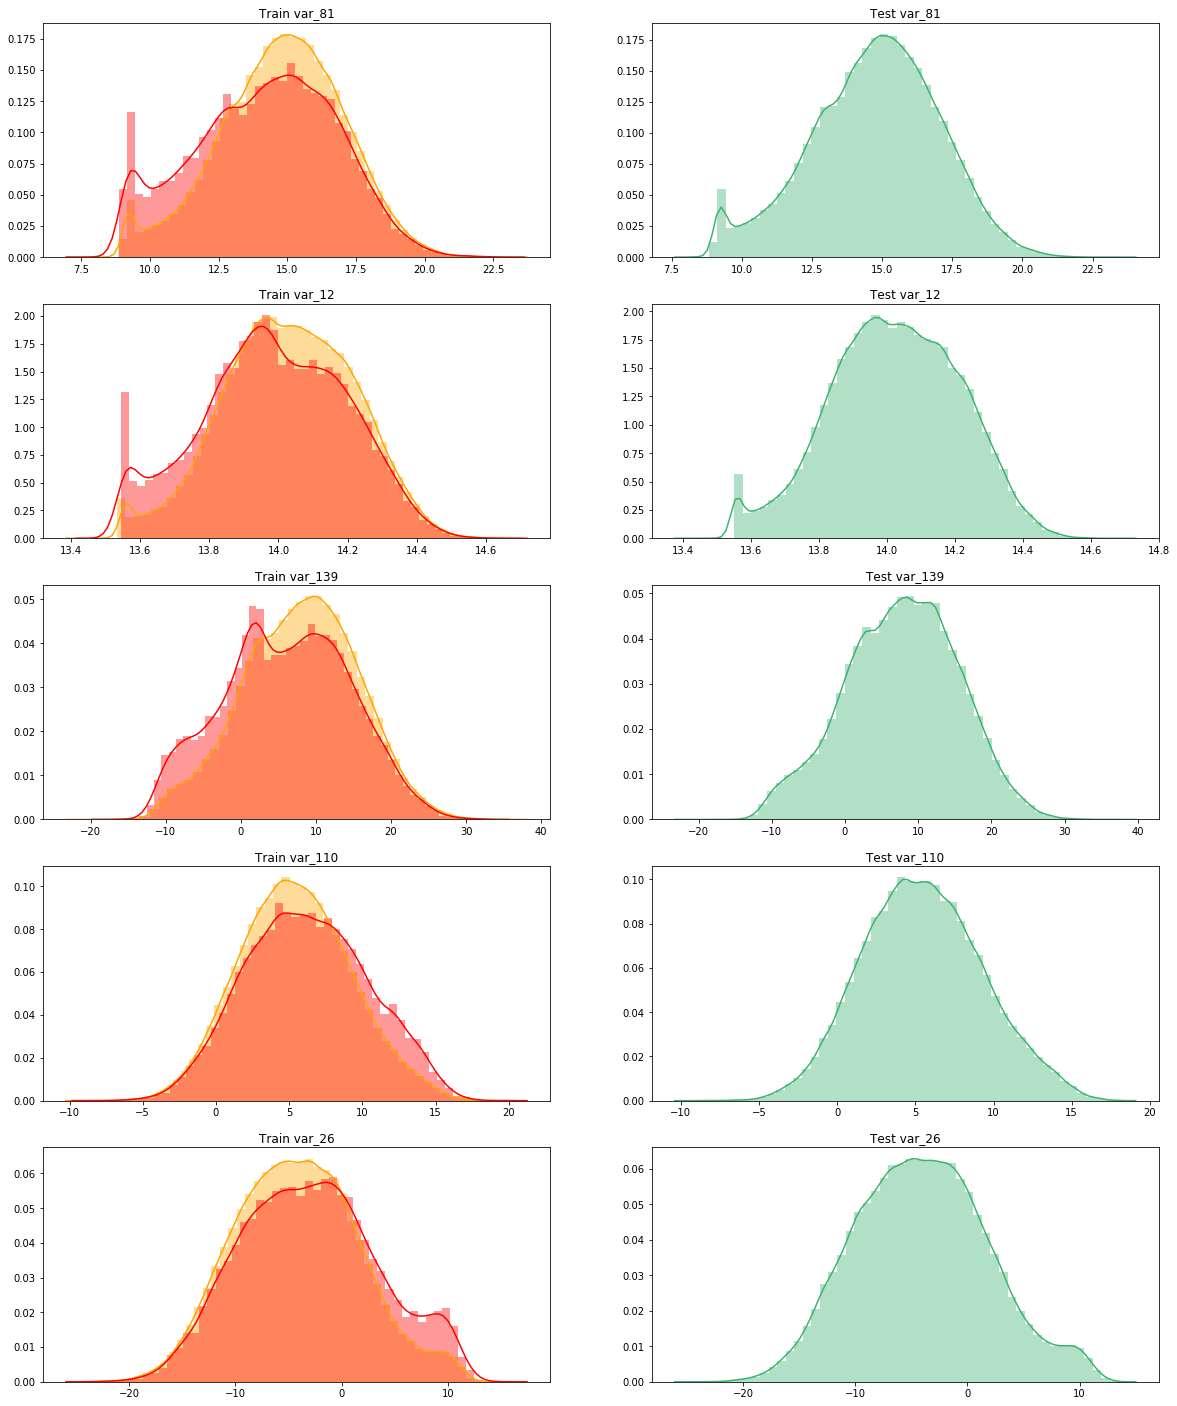

In [62]:
n_top = 5
fig, ax = plt.subplots(n_top, 2, figsize=(20, 5*n_top))

for n in range(n_top):
    sns.distplot(train.loc[train.target==0, feature_names[idx][n]], ax=ax[n,0], color="Orange", norm_hist=True)
    sns.distplot(train.loc[train.target==1, feature_names[idx][n]], ax=ax[n,0], color="Red", norm_hist=True)
    sns.distplot(test.loc[:, feature_names[idx][n]], ax=ax[n,1], color="Mediumseagreen", norm_hist=True)
    ax[n,0].set_title("Train {}".format(feature_names[idx][n]))
    ax[n,1].set_title("Test {}".format(feature_names[idx][n]))
    ax[n,0].set_xlabel("")
    ax[n,1].set_xlabel("")


In [63]:
top = train.loc[:, feature_names[idx]]
top.describe()

              var_81         var_12        var_139        var_110  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       14.719024      14.023978       7.760193       5.513238   
std         2.299567       0.190059       7.686433       3.823253   
min         7.586500      13.434600     -21.274300      -9.239800   
25%        13.214775      13.894000       2.387575       2.817475   
50%        14.844500      14.025500       8.066250       5.394300   
75%        16.340800      14.164200      13.232525       8.104325   
max        23.132400      14.654500      36.097100      19.519300   

              var_26  
count  200000.000000  
mean       -4.055133  
std         5.922210  
min       -24.243100  
25%        -8.321725  
50%        -4.196900  
75%        -0.090200  
max        15.675100  

LinAlgError: singular matrix

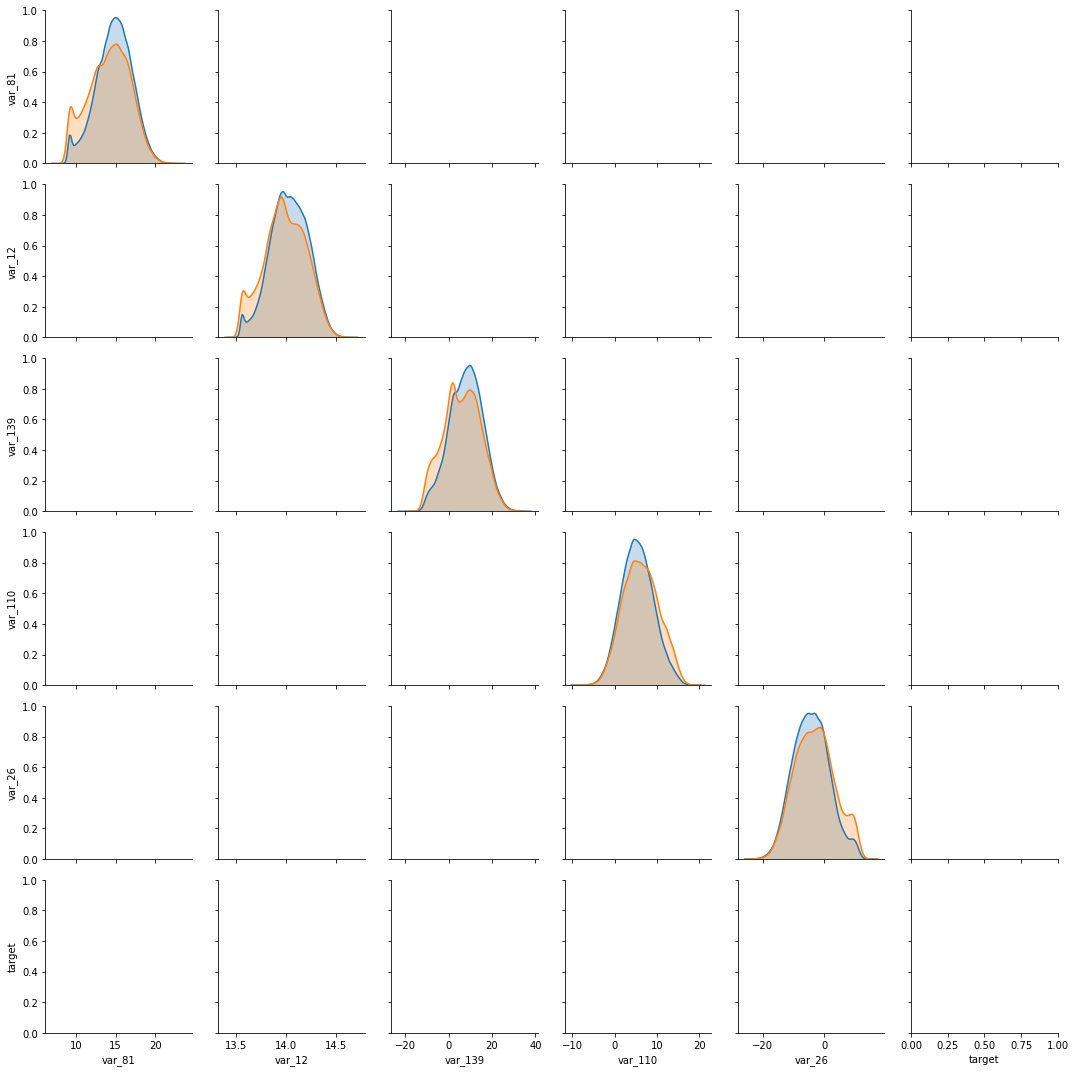

LinAlgError: singular matrix

In [64]:
top = top.join(train.target)
sns.pairplot(top, hue="target")

In [27]:
y_proba = grid.predict_proba(test.values)
y_proba_train = grid.predict_proba(train_upsampled.drop("target", axis=1).values)

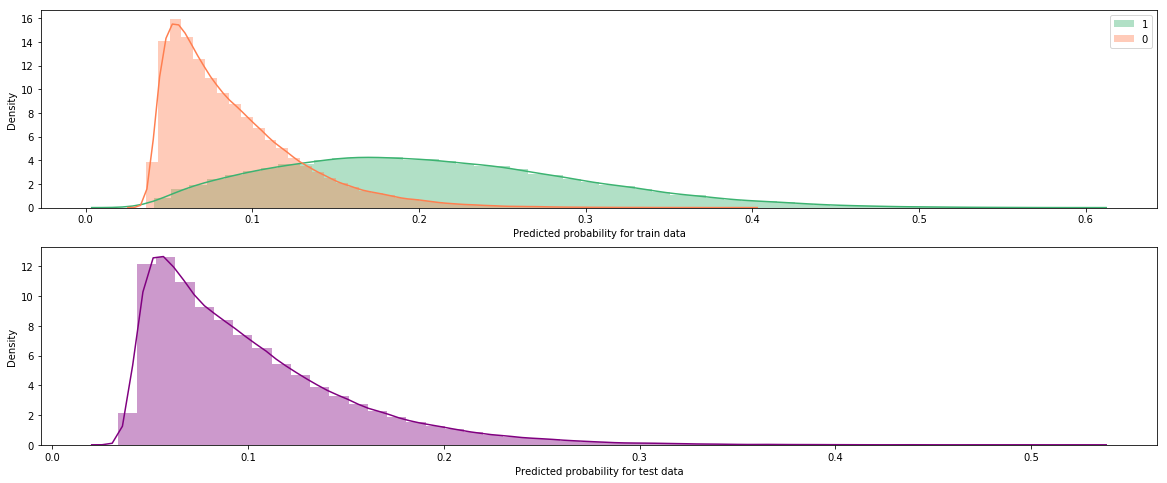

In [66]:
fig, ax = plt.subplots(2,1,figsize=(20,8))
sns.distplot(y_proba_train[train.target==1,1], norm_hist=True, color="mediumseagreen",
             ax=ax[0], label="1")
sns.distplot(y_proba_train[train.target==0,1], norm_hist=True, color="coral",
             ax=ax[0], label="0")
sns.distplot(y_proba[:,1], norm_hist=True,
             ax=ax[1], color="purple")
ax[1].set_xlabel("Predicted probability for test data");
ax[1].set_ylabel("Density");
ax[0].set_xlabel("Predicted probability for train data");
ax[0].set_ylabel("Density");
ax[0].legend();                                 

In [28]:
submission["target"] = y_proba
submission.to_csv("./submission_files/submission_baseline_forest_upsampled.csv", index=False)

In [68]:
original_features = train.drop(["target", "Id"], axis=1).columns.values
original_features

array(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13',
       'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19',
       'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25',
       'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31',
       'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37',
       'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43',
       'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49',
       'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55',
       'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61',
       'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67',
       'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73',
       'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79',
       'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85',
       'var_86', 'var_87', 'var_88', 'var_89', 'var_

In [69]:
encoder = LabelEncoder()
for your_feature in top.drop("target", axis=1).columns.values:
    train[your_feature + "_qbinned"] = pd.qcut(
        train.loc[:, your_feature].values,
        q=10,
        labels=False
    )
    train[your_feature + "_qbinned"] = encoder.fit_transform(
        train[your_feature + "_qbinned"].values.reshape(-1, 1)
    )
    
    
    train[your_feature + "_rounded"] = np.round(train.loc[:, your_feature].values)
    train[your_feature + "_rounded_10"] = np.round(10*train.loc[:, your_feature].values)
    train[your_feature + "_rounded_100"] = np.round(100*train.loc[:, your_feature].values)

/home/yang/.local/share/virtualenvs/santander/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
cv = StratifiedKFold(n_splits=3, random_state=0)
forest = RandomForestClassifier(max_depth=15, n_estimators=15, min_samples_leaf=20,
                                n_jobs=-1)

scores = []
X = train.drop("target", axis=1).values
y = train.target.values

for train_idx, test_idx in cv.split(X, y):
    x_train = X[train_idx]
    x_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    forest.fit(x_train, y_train)
    y_proba = forest.predict_proba(x_test)
    y_pred = np.zeros(y_proba.shape[0])
    y_pred[y_proba[:,1] >= 0.166] = 1
    
    score = roc_auc_score(y_test, y_pred)
    print(score)
    scores.append(score)

print(np.round(np.mean(scores),4))
print(np.round(np.std(scores), 4))

0.6514868128673601


0.65078799011945


0.5700982084406762
0.6241
0.0382


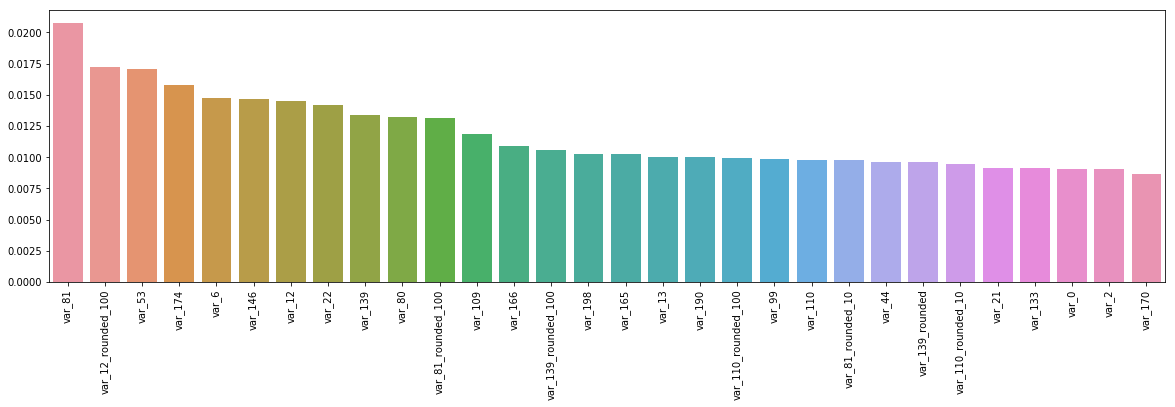

In [71]:
importances = forest.feature_importances_
feature_names = train.drop("target", axis=1).columns.values
idx = np.argsort(importances)[::-1][0:30]

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.xticks(rotation=90);

In [72]:
col1 = "var_81"
col2 = "var_12"
N = 70000

Text(0.5, 0, 'var_12')

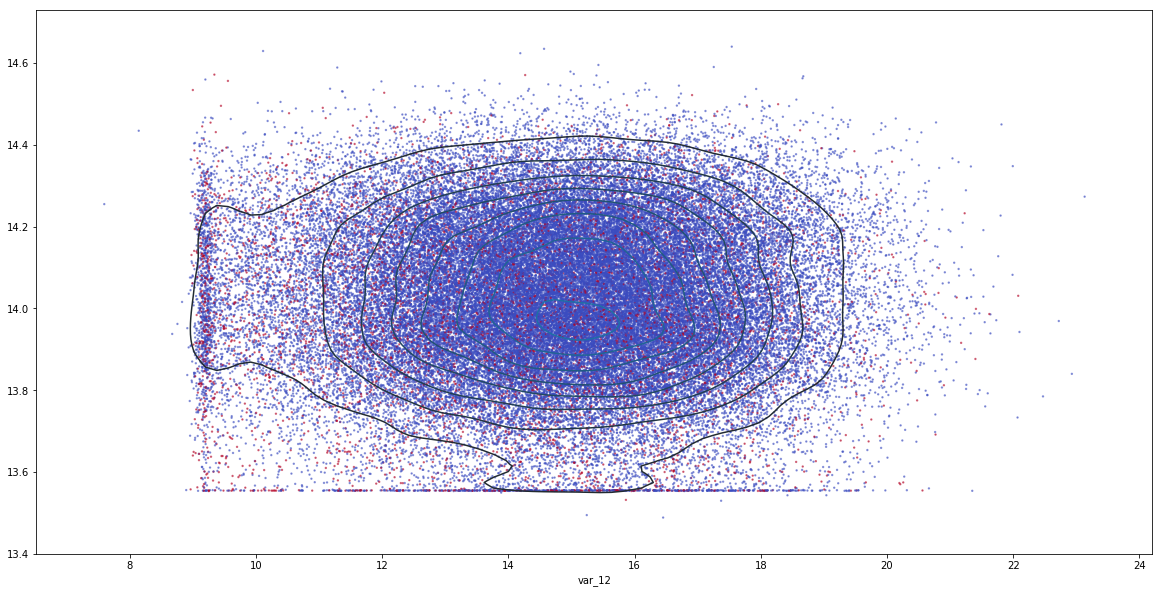

In [73]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.kdeplot(train[col1].values[0:N], train[col2].values[0:N])
ax.scatter(train[col1].values[0:N], train[col2].values[0:N],
           s=2, c=train.target.values[0:N], cmap="coolwarm", alpha=0.5)
ax.set_xlabel(col1)
ax.set_xlabel(col2)

In [75]:
combined = train.drop(["target", "Id"], axis=1).append(test.drop("Id", axis=1))
combined.shape                                 

/home/yang/.local/share/virtualenvs/santander/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(400000, 220)

In [76]:
max_components = 10
start_components = 3
n_splits = 3
K = train.shape[0]

X = train.loc[:, original_features].values[0:K]
y = train.target.values[0:K]                               

In [77]:
seeds = np.random.RandomState(0).randint(0, 100, size=(max_components-start_components))
seeds

array([44, 47, 64, 67, 67,  9, 83])

In [78]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)                                 

In [82]:
if fit_gaussians:
    components = np.arange(start_components, max_components, 1)
    kf = StratifiedKFold(random_state=0, n_splits=n_splits)
    
    scores = np.zeros(shape=(max_components-start_components, n_splits))

    for m in components:
        split=0
        print("Components " + str(m))
        for train_index, test_index in kf.split(X_scaled, y):
            print("Split " + str(split))
            x_train, x_test = X[train_index], X[test_index]
            gm = GaussianMixture(n_components=m, random_state=seeds[m-start_components])
            gm.fit(x_train)
            score = gm.score(x_test)
            scores[m-start_components,split] = score
            split +=1
    
    print(np.round(np.mean(scores, axis=1), 2))
    print(np.round(np.std(scores, axis=1), 2))
    best_idx = np.argmax(np.mean(scores, axis=1))
    best_component = components[best_idx]
    best_seed = seeds[best_idx]
    print("Best component found " + str(best_component))
    
else:
    best_seed = seeds[0]
    best_component = 3

In [83]:
X = train.loc[:, original_features].values

gm = GaussianMixture(n_components=best_component, random_state=best_seed)
X_scaled = scaler.transform(X)
gm.fit(X_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=44, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [84]:
train["cluster"] = gm.predict(X_scaled)
train["logL"] = gm.score_samples(X_scaled)
test["cluster"] = gm.predict(test.loc[:, original_features].values)
test["logL"] = gm.score_samples(test.loc[:, original_features].values)

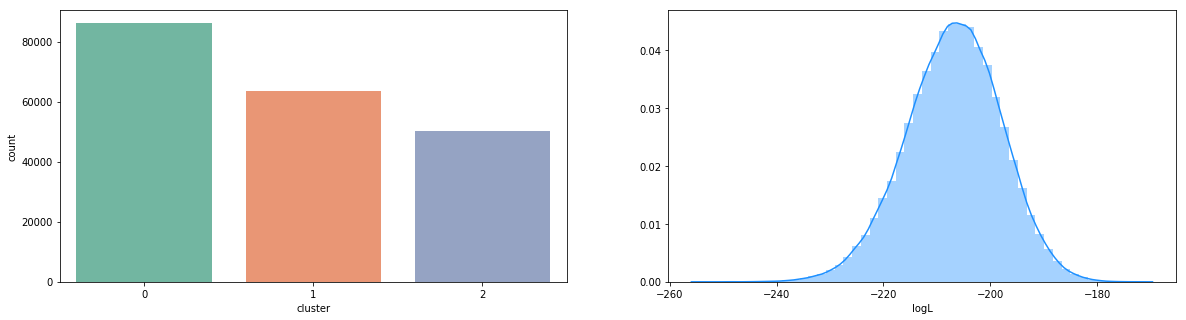

In [85]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.cluster, palette="Set2", ax=ax[0])
sns.distplot(train.logL, color="Dodgerblue", ax=ax[1]);

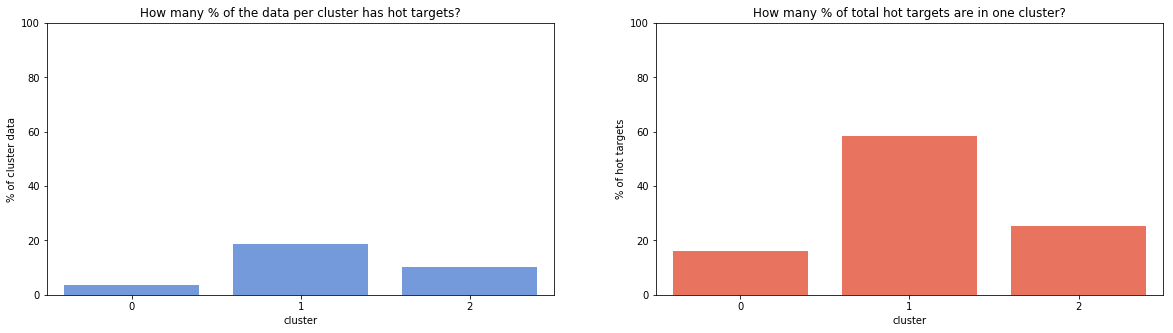

In [86]:
cluster_occupation = train.groupby("cluster").target.value_counts() / train.groupby("cluster").size() * 100
cluster_occupation = cluster_occupation.loc[:, 1]

target_occupation = train.groupby("target").cluster.value_counts() / train.groupby("target").size() * 100
target_occupation = target_occupation.loc[1, :]
target_occupation.index = target_occupation.index.droplevel("target")

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("How many % of the data per cluster has hot targets?")
sns.barplot(cluster_occupation.index, cluster_occupation.values, ax=ax[0], color="cornflowerblue")
ax[0].set_ylabel("% of cluster data")
ax[0].set_ylim([0,100])

ax[1].set_title("How many % of total hot targets are in one cluster?")
sns.barplot(target_occupation.index, target_occupation.values, ax=ax[1], color="tomato")
ax[1].set_ylabel("% of hot targets")
ax[1].set_ylim([0,100]);

Text(0.5, 0, 'Feature')

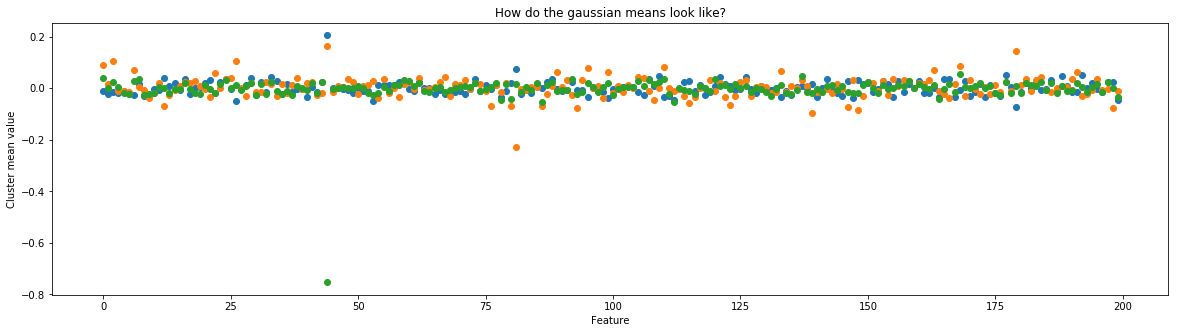

In [87]:
plt.figure(figsize=(20,5))
for n in range(gm.means_.shape[0]):
    plt.plot(gm.means_[n,:], 'o')
plt.title("How do the gaussian means look like?")
plt.ylabel("Cluster mean value")
plt.xlabel("Feature")